# Divertor Silhouette Tutorial
This tutorial goes through different divertor silhouette build recipes in BLUEPRINT.

The design recipe chosen to shape the divertor can vary depending on the design
intent of the reactor and the level of fidelity needed. This example shows a few
simple divertor recipes that are supported out of the box by BLUEPRINT. Note that
some of these recipes will be more or less appropriate for different choices of
reactor parameterisations.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from BLUEPRINT.base.parameter import ParameterFrame
from BLUEPRINT.base.file import get_BP_root
from BLUEPRINT.geometry.geomtools import unique
from BLUEPRINT.geometry.loop import Loop
from BLUEPRINT.nova.firstwall import FirstWallProfile
from BLUEPRINT.nova.stream import StreamFlow
from BLUEPRINT.systems.divertor_silhouette import (  # noqa(F401)
    DivertorSilhouette,
    DivertorSilhouetteFlatDome,
    DivertorSilhouettePsiBaffle,
    DivertorSilhouetteFlatDomePsiBaffle,
)

plt.ion()
plt.show()

DEBUG:git.cmd:Popen(['git', 'version'], cwd=/home/dshort/code/BLUEPRINT/examples/systems, universal_newlines=False, shell=None, istream=None)
DEBUG:git.cmd:Popen(['git', 'version'], cwd=/home/dshort/code/BLUEPRINT/examples/systems, universal_newlines=False, shell=None, istream=None)
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


## Setting BLUEPRINT Parameters
When creating any `ReactorSystem` in BLUEPRINT, we need to set the relevant parameters.
The list below gives a basic set of values for a `FirstWallProfile` + `DivertorProfile`
build, which we will use in this tutorial. You can edit the third element in each row
to change the parameter's value.

We'll also build the BLUEPRINT `ParameterFrame` from that list.

In [2]:
params = [
    ["Name", "The reactor name", "DIV_TEST", "N/A", None, "Input"],
    ["plasma_type", "Type of plasma", "DN", "N/A", None, "Input"],
    ["A", "Plasma aspect ratio", 1.667, "N/A", None, "Input"],
    ["R_0", "Major radius", 2.5, "m", None, "Input"],
    ["fw_dL_min", "Minimum FW module length", 0.75, "m", None, "Input"],
    ["fw_dL_max", "Maximum FW module length", 3, "m", None, "Input"],
    ["fw_a_max", "Maximum angle between FW modules", 20, "°", None, "Input"],
    ["fw_psi_n", "Normalised psi boundary to fit FW to", 1.005, "N/A", None, "Input"],
    ["div_L2D_ib", "Inboard divertor leg length", 0.3, "m", None, "Input"],
    ["div_L2D_ob", "Outboard divertor leg length", 3.0, "m", None, "Input"],
    ["div_graze_angle", "Divertor SOL grazing angle", 15.0, "°", None, "Input"],
    ["div_Ltarg", "Divertor target length", 1.0, "m", None, "Input"],
    ["div_open", "Divertor open/closed configuration", True, "N/A", None, "Input"],
    ["div_r_min", "Divertor minimum radial extent", 0.25, "m", None, "Input"],
    ["tk_div", "Divertor thickness", 0.1, "m", None, "Input"],
    ["tk_sol_ib", "Inboard SOL thickness", 0.011, "m", None, "Input"],
    ["tk_sol_ob", "Outboard SOL thickness", 0.06, "m", None, "Input"],
    ["bb_gap", "Gap between divertor and breeding blanket", 0.05, "m", None, "Input"],
    ["r_fw_ib_in", "Inboard first wall inner radius", 0.92, "m", None, "PROCESS"],
    ["r_fw_ob_in", "Outboard first wall inner radius", 4.17, "m", None, "PROCESS"],
]

params = ParameterFrame(params)

Let's also select an equilibrium to read in so that we can shape our first wall and
divertor around it. We'll also make a `StreamFlow` object from that equilibrium file.
A `StreamFlow` contains utilities for the analysis of equilibrium information.

In [3]:
eq_filename = os.path.join(get_BP_root(), "data", "eqdsk", "step_v7_format.geqdsk")
sf = StreamFlow(eq_filename)

## Creating a FirstWallProfile
Now we'll make a `FirstWallProfile` using a spline shape parameterisation and generate
the first wall shape using a flux offset from the plasma boundary.

In [4]:
first_wall = FirstWallProfile(
    params,
    {
        "name": params.Name,
        "parameterisation": "S",
    },
)

first_wall.generate(
    [eq_filename],
    dx=params.tk_sol_ib,
    psi_n=params.fw_psi_n,
    flux_fit=True,
)

+-------------------------------------------------------------------------+
| PolySpline optimisation time: 0.8 s                                     |
+-------------------------------------------------------------------------+


Let's discretise and clean up our first wall so that we can take a look at it.

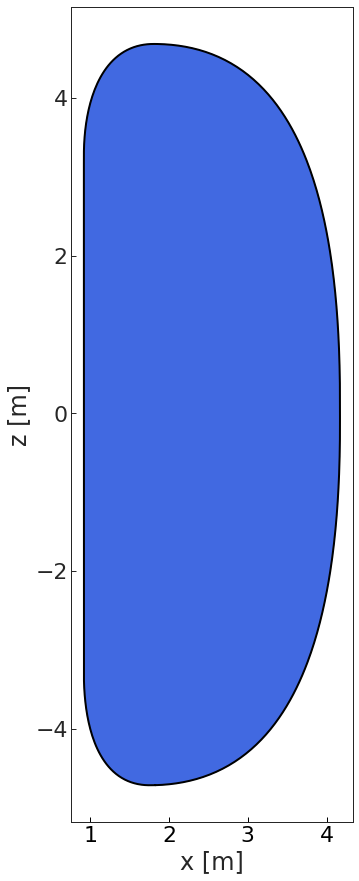

In [5]:
x, z = first_wall.draw(npoints=500)
istart = np.argmin((x - sf.x_point[0]) ** 2 + (z - sf.x_point[1]) ** 2)
x = np.append(x[istart:], x[: istart + 1])
z = np.append(z[istart:], z[: istart + 1])
x, z = unique(x, z)[:2]
fw_loop = Loop(x=x, z=z)
fw_loop.plot()

## Targets Definitions
The divertor is shaped using a parameterisation of the targets. This is provided to
the `DivertorSilhouette` as a dictionary containing the relevant default settings and
any specific settings for either leg.

In [6]:
targets = {}
targets["default"] = {}
targets["inner"] = {}
targets["outer"] = {}
targets["default"]["L2D"] = params.div_L2D_ib
targets["default"]["open"] = params.div_open
targets["default"]["graze"] = params.div_graze_angle * np.pi / 180
targets["default"]["dPlate"] = params.div_Ltarg
targets["default"]["dR"] = 0
targets["inner"]["open"] = params.div_open
targets["outer"]["open"] = params.div_open
targets["inner"]["L2D"] = params.div_L2D_ib
targets["outer"]["L2D"] = params.div_L2D_ob

## Making the DivertorSilhouette
Now we have enough information to create an instance of our `DivertorSilhouette` class.
There are a few options available, so comment out / in the recipe that you'd like to
run. We also create an input dictionary to the class to contain any arguments that are
needed beyond our `ParameterFrame`.

In [7]:
to_dp = {
    "sf": sf,
    "targets": targets,
}

# div = DivertorSilhouette(params, to_dp)
# div = DivertorSilhouetteFlatDome(params, to_dp)
# div = DivertorSilhouettePsiBaffle(params, to_dp)
div = DivertorSilhouetteFlatDomePsiBaffle(params, to_dp)

## Make Some Divertor Targets
We can use our `DivertorSilhouette` to generate some target shapes - these are just
numpy arrays, so can be manipulated if you'd like. We'll just plot them for now along
with the scrape off layer legs.

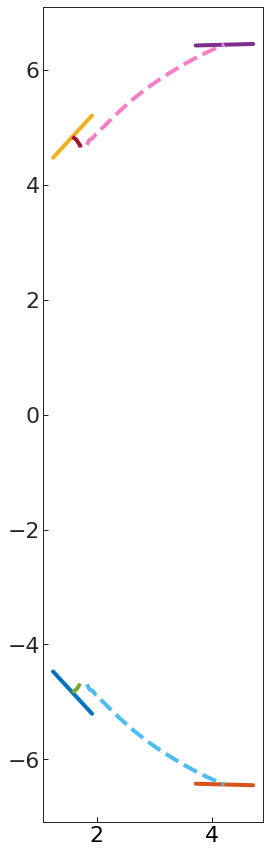

In [8]:
div_targets = {}
div_targets["lower"] = {}
div_targets["upper"] = {}
div_targets["lower"]["inner"] = div.make_target("lower", "inner")
div_targets["lower"]["outer"] = div.make_target("lower", "outer")
div_targets["upper"]["inner"] = div.make_target("upper", "inner")
div_targets["upper"]["outer"] = div.make_target("upper", "outer")

plt.plot(div_targets["lower"]["inner"].T[0], div_targets["lower"]["inner"].T[1])
plt.plot(div_targets["lower"]["outer"].T[0], div_targets["lower"]["outer"].T[1])
plt.plot(div_targets["upper"]["inner"].T[0], div_targets["upper"]["inner"].T[1])
plt.plot(div_targets["upper"]["outer"].T[0], div_targets["upper"]["outer"].T[1])
plt.gca().set_aspect("equal")

sol = div.get_sol_leg("lower", "inner")
plt.plot(sol[0], sol[1], "--")
sol = div.get_sol_leg("lower", "outer")
plt.plot(sol[0], sol[1], "--")
sol = div.get_sol_leg("upper", "inner")
plt.plot(sol[0], sol[1], "--")
sol = div.get_sol_leg("upper", "outer")
plt.plot(sol[0], sol[1], "--")

## Make Some Domes
Next we'll make some dome sections, which connect the inner and outer targets.

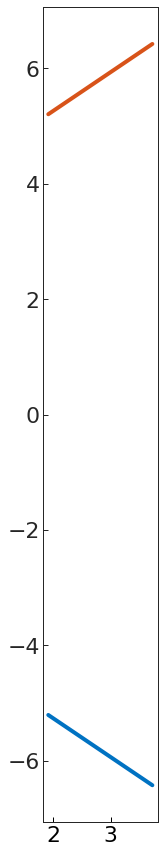

In [9]:
domes = {}
domes["lower"] = div.make_dome(
    "lower", div_targets["lower"]["inner"][-1], div_targets["lower"]["outer"][0]
)
domes["upper"] = div.make_dome(
    "upper", div_targets["upper"]["inner"][-1], div_targets["upper"]["outer"][0]
)
plt.plot(domes["lower"].T[0], domes["lower"].T[1])
plt.plot(domes["upper"].T[0], domes["upper"].T[1])
plt.gca().set_aspect("equal")

## Make Some Baffles
Finally we'll make some baffles, which will connect the divertor to the first wall.

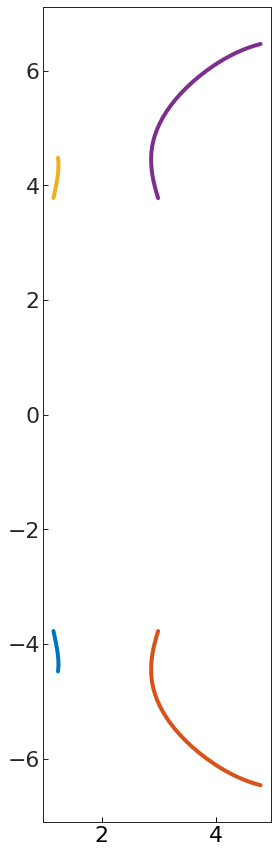

In [10]:
baffles = {}
baffles["lower"] = {}
baffles["upper"] = {}

baffles["lower"]["inner"] = div.make_baffle(
    "lower", "inner", div_targets["lower"]["inner"]
)
baffles["lower"]["outer"] = div.make_baffle(
    "lower", "outer", div_targets["lower"]["outer"]
)
baffles["upper"]["inner"] = div.make_baffle(
    "upper", "inner", div_targets["upper"]["inner"]
)
baffles["upper"]["outer"] = div.make_baffle(
    "upper", "outer", div_targets["upper"]["outer"]
)
plt.plot(baffles["lower"]["inner"].T[0], baffles["lower"]["inner"].T[1])
plt.plot(baffles["lower"]["outer"].T[0], baffles["lower"]["outer"].T[1])
plt.plot(baffles["upper"]["inner"].T[0], baffles["upper"]["inner"].T[1])
plt.plot(baffles["upper"]["outer"].T[0], baffles["upper"]["outer"].T[1])
plt.gca().set_aspect("equal")

## The DivertorSilhouette Build
In reality we don't want to be building each section of the divertor by hand.
Fortunately the `DivertorSilhouette` has a `make_divertor` and a `build` method to
bring all of this together - use `build` if you want to build the full divertor system
with the upper and lower divertor, or use `make_divertor` if you just want to make a
single divertor in isolation. The different component sections are stored in the `geom`
dictionary, so we can make some plots of the divertor shape as below. We'll make use
of our first wall `Loop` to connect the divertor up.

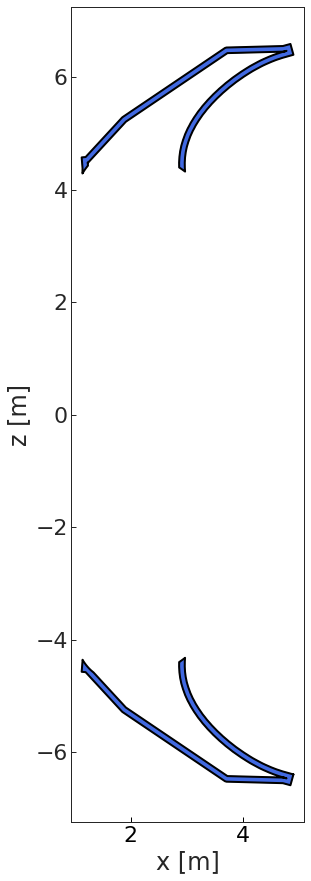

In [11]:
div.build(fw_loop)
div.geom["divertors"]["upper"].plot()
div.geom["divertors"]["lower"].plot()

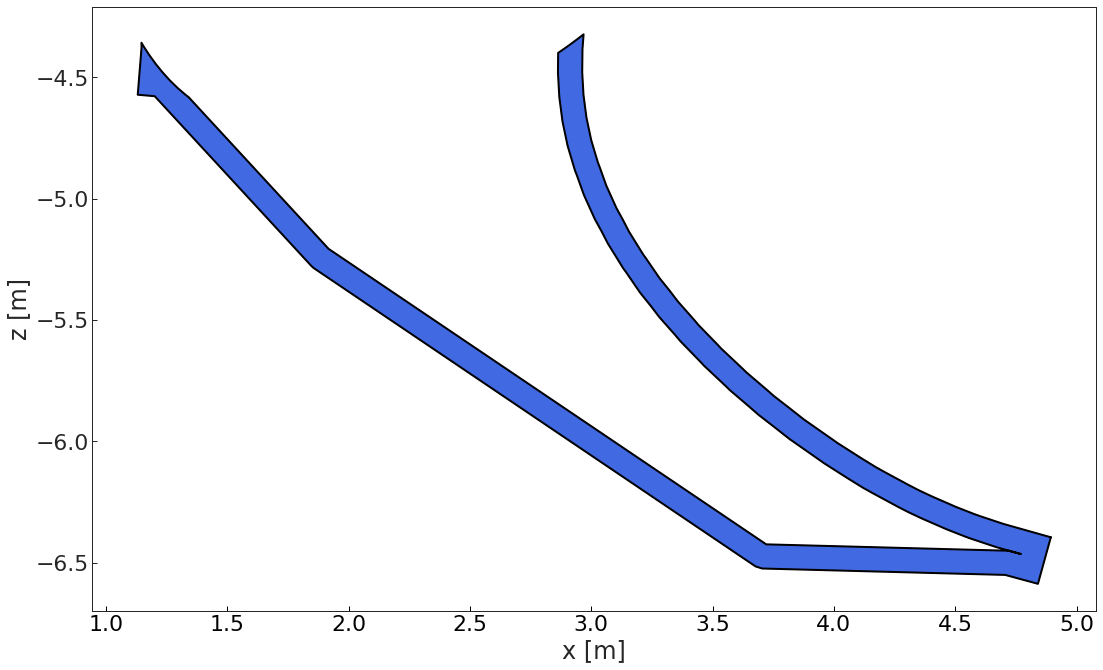

In [12]:
div_geom = div.make_divertor(fw_loop, "lower")
div_geom["divertor"].plot()